# DS 5001 Project Notebook: Greek and Roman Mythology

- David Vann (dv6bq@virginia.edu)
- DS 5001
- 5 May 2021

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import nltk

from eta_modules.preprocessing import Document, Corpus
from eta_modules.analysis import HierarchicalClusterAnalysis, PCA, TopicModel, WordEmbedding, SentimentAnalysis

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

## Reading in the data

We start by loading in the XML files for each work and parsing them to a reasonable degree with BeautifulSoup and NLTK. 

Since these works are all either plays or poems/epics, the concept of a "chapter" or "paragraph" doesn't translate perfectly compared to, e.g., a novel. However, the Perseus Digital Library (where these files are sourced from) has added at least top-level divisions to break up texts. In some cases, these divisions truly exist in the text (for example, *The Iliad* is broken into 24 books); in other cases, like plays, these divisions don't seem to be directly present in the text, but are akin to something like a "scene". I've considered all of these largest divisions as "chapters".

To get at something like a "paragraph", I used a different approach based on whether the work was a play or not:

- For plays, I used each speaker section (denoted by a "\<sp>" in the files) as a "paragraph". 
- For everything else, there wasn't a built-in tag for "paragraph"-type divisions, but there is a self-closing "milestone" tag that marks the start of a new "card" used on the Perseus website to denote content to be displayed on one page. Since these are self-closing, they don't actually enclose the particular block of text that I wanted to get at; instead, I replaced these with newlines and split up text based on a double newline, which seemed to give fairly satisfactory results.

In [3]:
def parse_corpus(docpaths, tfidf_bag=['work_id', 'chapter_id'], tfidf_methods=['n', 'max', 'bool']):
    doc_list = []
    for path in docpaths:
        doc = Document(path)
        doc.parse_text_to_paras()
        doc.tokenize(remove_pos_tuple=True, remove_ws=True)
        doc_list.append(doc)

    corpus = Corpus(doc_list)
    corpus.extract_annotate_vocab()
    corpus.compute_tfidf(OHCO_level=tfidf_bag, methods=tfidf_methods)
    
    return doc_list, corpus


# Annotating the vocabulary uses NLTK and is slow since it's not a vectorized operation, so it's much faster to reload the tables if they already exist
# Still recompute TFIDF since bags/methods can differ between calculations
def load_corpus(docpaths=None, table_dir=None, tfidf_bag=['work_id', 'chapter_id'], tfidf_methods=['n', 'max', 'bool']):
    if table_dir is not None:
        corpus_filepaths = glob(os.path.join(table_dir, '*.csv'))
        if len(corpus_filepaths) != 0:
            corpus = Corpus()
            corpus.load_tables(table_dir)
            corpus.compute_tfidf(OHCO_level=tfidf_bag, methods=tfidf_methods)
            output = ([], corpus)
    elif docpaths is not None:
        doc_list, corpus = parse_corpus(docpaths=docpaths, tfidf_bag=tfidf_bag, tfidf_methods=tfidf_methods)
        output = (doc_list, corpus)
    
    return output

In [4]:
root_dir = os.path.abspath('..')
data_dir = os.path.join(root_dir, 'data')
output_dir = os.path.join(data_dir, 'outputs')

docpaths = glob(os.path.join(data_dir, 'raw', '**', '*.xml'), recursive=True) # Get all XML file paths
table_dir = os.path.join(output_dir, 'corpus')

OHCO = ['work_id', 'chapter_id', 'para_id', 'sent_id']
book_bag = OHCO[:1]
chapter_bag = OHCO[:2]
paragraph_bag = OHCO[:3]

In [5]:
doc_list, corp = load_corpus(table_dir=table_dir, tfidf_bag=chapter_bag) # doc_list is empty here, but it's not very important for most work
# doc_list, corp = load_corpus(docpaths=docpaths, tfidf_bag=chapter_bag) # parse from scratch

In [6]:
corp.vocab.sort_values('tfidf_bool_sum', ascending=False).head(10)

,n,stop,p_stem,pos_max,df,idf,tfidf_n_sum,tfidf_max_sum,tfidf_bool_sum
term_str,,,,,,,,,
sing,87,0,sing,VBG,58.0,2.208108,1.818238,4.661145,21.177994
hail,96,0,hail,NNP,66.0,2.021695,1.836953,4.764529,18.295464
song,172,0,song,NN,81.0,1.726239,2.810221,5.019835,15.144377
begin,51,0,begin,VB,38.0,2.818162,1.360339,3.795305,13.906330
chorus,841,0,choru,NNP,138.0,0.957565,7.622109,5.562190,12.180397
zeus,1270,0,zeu,NNP,170.0,0.656698,7.893700,4.092469,9.613901
muse,22,0,muse,NNP,18.0,3.896164,0.811280,2.520024,9.230295
lovely,152,0,love,JJ,53.0,2.338169,3.363802,4.336044,8.754176
bare,173,0,bare,NN,63.0,2.088809,3.420235,4.530838,8.595742


## Hierarchical Clustering based on TF-IDF

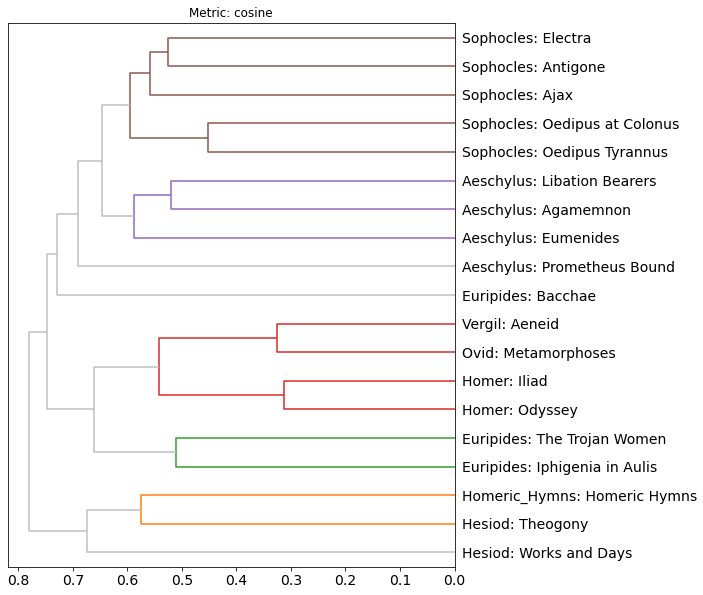

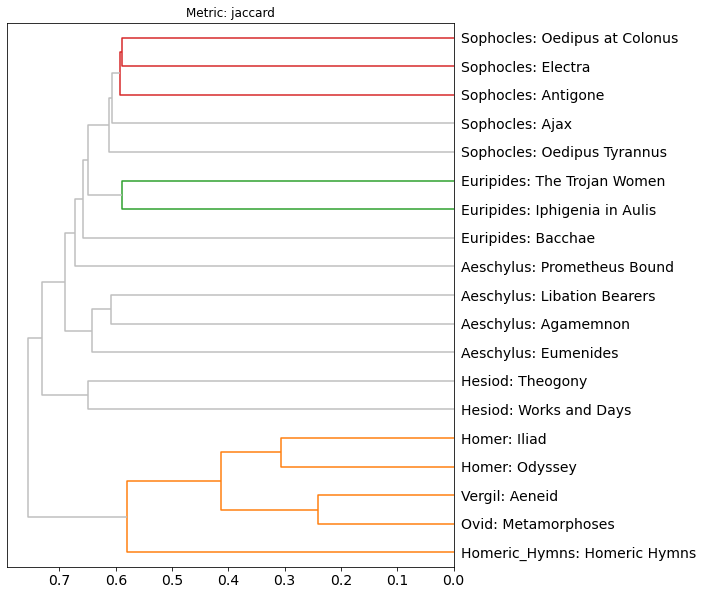

In [7]:
hca = HierarchicalClusterAnalysis(max_features=6000, tfidf_method='max', OHCO_level=chapter_bag)
hca.fit(corp, metrics=['cosine', 'jaccard'])
hca.plot_dendrogram(linkage='complete', color_thresh=0.6, figsize=(8, 10))

## Principal Components Analysis

In [8]:
pca = PCA(max_features=6000, tfidf_method='max', OHCO_level=chapter_bag)
pca.fit(corp, n_components=10)

In [9]:
pca.dcm

pc_id                              PC0       PC1       PC2       PC3  \
author    work_id chapter_id                                           
Aeschylus 2       0           0.057426  0.013750  0.010696  0.053764   
                  1           0.053741  0.019013  0.017303  0.036515   
                  2           0.043507  0.034898 -0.002663  0.036651   
                  3           0.071096  0.018624 -0.022272  0.024056   
                  4           0.023459  0.066730 -0.086483  0.004883   
...                                ...       ...       ...       ...   
Vergil    14      7          -0.251772  0.297499  0.219325  0.035479   
                  8          -0.278540  0.281587  0.192345  0.092611   
                  9          -0.279309  0.303880  0.192073  0.098777   
                  10         -0.268927  0.315332  0.163244  0.090771   
                  11         -0.291164  0.299768  0.168892  0.098475   

pc_id                              PC4       PC5       PC6       PC7  \
author    work_id chapter_id                                           
Aeschylus 2       0          -0.074258 -0.079247 -0.047119  0.047193   
                  1          -0.052536 -0.086453 -0.025953  0.035217   
                  2          -0.069674 -0.110034 -0.052553  0.057560   
                  3          -0.062667 -0.035713 -0.065785  0.086352   
                  4          -0.068629 -0.112378  0.008369  0.022922   
...                                ...       ...       ...       ...   
Vergil    14      7          -0.105269  0.019183 -0.162497 -0.117141   
                  8          -0.115904 -0.001317 -0.136819 -0.147361   
                  9          -0.148996 -0.004529 -0.159979 -0.155516   
                  10         -0.120103 -0.004754 -0.166679 -0.135112   
                  11         -0.125497  0.034764 -0.144095 -0.138387   

pc_id                              PC8       PC9  
author    work_id chapter_id                      
Aeschylus 2       0           0.012682 -0.002125  
                  1           0.027009  0.052213  
                  2           0.058380  0.036592  
                  3           0.027128  0.037207  
                  4           0.062903  0.017958  
...                                ...       ...  
Vergil    14      7           0.097755 -0.086114  
                  8           0.074500 -0.123860  
                  9           0.076915 -0.102856  
                  10          0.096782 -0.121169  
                  11          0.101413 -0.096327  

[268 rows x 10 columns]

In [10]:
pca.plot_2d(comp_id_1=0, comp_id_2=1)

In [11]:
pca.plot_2d(comp_id_1=1, comp_id_2=2)

In [12]:
lda = TopicModel(remove_proper_nouns=True, max_features=6000, max_iter=25, n_topics=30, random_state=0)
lda.fit(corp)

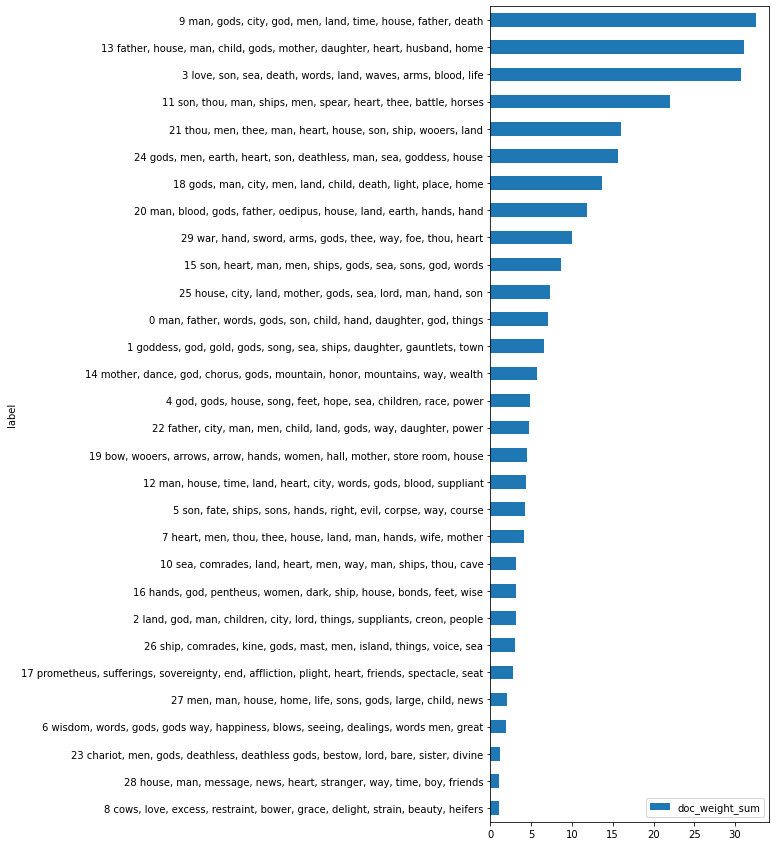

In [13]:
lda.plot_topic_weights()

In [14]:
lda.author_topic.style.background_gradient()

author,Aeschylus,Euripides,Hesiod,Homer,Homeric_Hymns,Ovid,Sophocles,Vergil,label
topic_id,,,,,,,,,
0,0.022132,0.051411,0.000018,0.000025,0.001476,0.000018,0.056298,0.000016,"0 man, father, words, gods, son, child, hand, daughter, god, things"
1,0.001059,0.034579,0.000018,0.000025,0.130114,0.000018,0.013457,0.007630,"1 goddess, god, gold, gods, song, sea, ships, daughter, gauntlets, town"
2,0.000434,0.000256,0.000018,0.000025,0.030567,0.000018,0.026756,0.000016,"2 land, god, man, children, city, lord, things, suppliants, creon, people"
3,0.106442,0.096670,0.000018,0.001952,0.011784,0.854819,0.044697,0.465278,"3 love, son, sea, death, words, land, waves, arms, blood, life"
4,0.000434,0.000256,0.000018,0.000025,0.083847,0.000018,0.026351,0.000016,"4 god, gods, house, song, feet, hope, sea, children, race, power"
5,0.000434,0.030368,0.000018,0.000025,0.001476,0.000018,0.041530,0.000016,"5 son, fate, ships, sons, hands, right, evil, corpse, way, course"
6,0.000434,0.000256,0.000018,0.000025,0.027450,0.000018,0.012486,0.000016,"6 wisdom, words, gods, gods way, happiness, blows, seeing, dealings, words men, great"
7,0.000434,0.030422,0.000018,0.021004,0.061945,0.000018,0.000424,0.000016,"7 heart, men, thou, thee, house, land, man, hands, wife, mother"
8,0.000434,0.030062,0.000018,0.000025,0.001476,0.000018,0.000424,0.000016,"8 cows, love, excess, restraint, bower, grace, delight, strain, beauty, heifers"


## Word Embeddings (word2vec)

In [15]:
w2v = WordEmbedding(OHCO_level=paragraph_bag)
w2v.fit(corp)

In [16]:
w2v.plot_tsne(random_state=0)

In [17]:
w2v.word_analogy('war', 'glory', 'peace', n=10)

,term,sim
0,husband,0.990350
1,marriage,0.989421
2,age,0.988164
3,sorrow,0.987560
4,deed,0.986996
5,evil,0.985416
6,tale,0.985195
7,woman,0.985151
8,cause,0.984933
9,told,0.984927


In [18]:
w2v.word_analogy('men', 'brave', 'women', n=10)

,term,sim
0,right,0.988740
1,tender,0.988144
2,form,0.987865
3,lyre,0.987694
4,glad,0.987507
5,warrior,0.987170
6,cried,0.987018
7,felt,0.986974
8,moment,0.986868
9,knew,0.986810


## Sentiment Analysis

In [19]:
nrc_lexicon_path = os.path.join(data_dir, 'lexicons', 'salex_nrc.csv')
sa = SentimentAnalysis(nrc_lexicon_path)
sa.fit(corp)

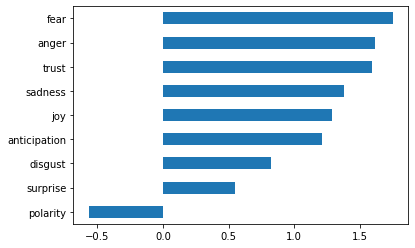

In [20]:
sa.plot_mean_sentiments(author='homer')

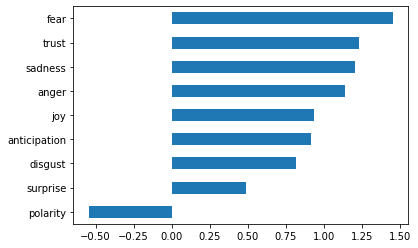

In [21]:
sa.plot_mean_sentiments(author='aeschylus')

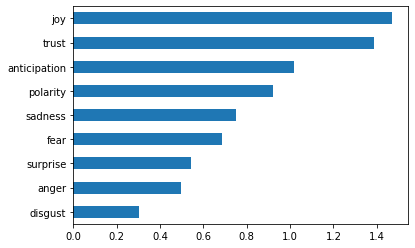

In [22]:
sa.plot_mean_sentiments(work_title='homeric hymns')

In [23]:
sa.get_chapter_table(work_title="iliad").style.background_gradient(cmap="YlGn")

## Saving Tables

In [24]:
# # Saving tables
# corp.save_tables(os.path.join(output_dir, 'corpus'))